Import of packages

In [163]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns

from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, BatchNormalization, AveragePooling2D
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

Function for loading the labeled dataset in correct order

In [164]:
def load_data(dataset_dir, labes_dir):
    # Load the labels
    labels_df = pd.read_csv(labes_dir)

    # Sort labels by ID to ensure the order matches the .npy file order
    labels_df = labels_df.sort_values('ID').reset_index(drop=True)

    # Initialize lists to collect data and labels
    data_list = []
    labels_list = []

    # Loop over IDs in order
    for idx, row in labels_df.iterrows():
        file_path = os.path.join(dataset_dir, f"{row['ID']}.npy")
        data = np.load(file_path)
        data_list.append(data)
        labels_list.append(row['target'])

    # Convert to numpy arrays
    dataset = np.array(data_list)
    dataset_labels = np.array(labels_list)
    
    return dataset, dataset_labels

Loading the dataset

In [165]:
TRAIN_DIR = 'C:/Users/Martin/Documents/REPO/MPA-MLF/Project/MPA-MLF_DATA_NEW/Train/'
TEST_DIR = 'C:/Users/Martin/Documents/REPO/MPA-MLF/Project/MPA-MLF_DATA_NEW/Test/'
LABEL_PATH = 'C:/Users/Martin/Documents/REPO/MPA-MLF/Project/MPA-MLF_DATA_NEW/label_train.csv'
EMPTY_LABEL_PATH = 'C:/Users/Martin/Documents/REPO/MPA-MLF/Project/MPA-MLF_DATA_NEW/test_format.csv'

dataset, dataset_labels = load_data(TRAIN_DIR, LABEL_PATH)
submition_data, submition_data_labels = load_data(TEST_DIR, EMPTY_LABEL_PATH)

print(f"Data shape: {dataset.shape}")
print(f"Labels shape: {dataset_labels.shape}")
print(f"Test data shape: {submition_data.shape}")
print(f"Test labels shape: {submition_data_labels.shape}")

nodeB_0 = dataset[dataset_labels == 0]
nodeB_1 = dataset[dataset_labels == 1]
nodeB_2 = dataset[dataset_labels == 2]
print("Num of nodeB_0:", nodeB_0.shape[0], "\nNum of nodeB_1:", nodeB_1.shape[0], "\nNum of nodeB_2:", nodeB_2.shape[0], "\n")

Data shape: (1491, 72, 48)
Labels shape: (1491,)
Test data shape: (120, 72, 48)
Test labels shape: (120,)


Visualise one train LTE frame sample

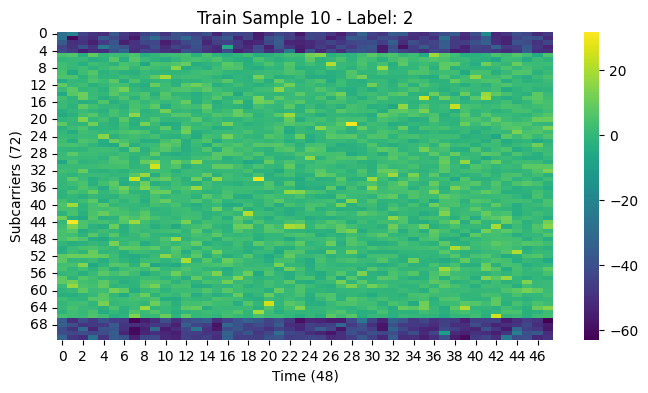

In [166]:
i = 10
plt.figure(figsize=(8, 4))
sns.heatmap(dataset[i], cmap='viridis')
plt.title(f"Train Sample {i} - Label: {int(dataset_labels[i])}")
plt.xlabel("Time (48)")
plt.ylabel("Subcarriers (72)")
plt.show()

Enlarging the dataset by adding samples with noise

In [167]:
nodeB_0 = dataset[dataset_labels == 0]
nodeB_1 = dataset[dataset_labels == 1]
nodeB_2 = dataset[dataset_labels == 2]
print("Num of nodeB_0:", nodeB_0.shape[0], "\nNum of nodeB_1:", nodeB_1.shape[0], "\nNum of nodeB_2:", nodeB_2.shape[0], "\n")

""" for k in range(2):
    nodeB_0 = nodeB_0 + np.random.normal(0, 1, (nodeB_0.shape[0], nodeB_0.shape[1], nodeB_0.shape[2]))
    dataset = np.append(dataset, nodeB_0, 0)
    dataset_labels = np.append(dataset_labels, np.zeros(nodeB_0.shape[0]))
    
N_nodeB_0 = np.count_nonzero(dataset_labels == 0)

for k in range(N_nodeB_0//nodeB_1.shape[0]):
    nodeB_1 = nodeB_1 + np.random.normal(0, 1+k/(N_nodeB_0//nodeB_1.shape[0]), (nodeB_1.shape[0], nodeB_1.shape[1], nodeB_1.shape[2]))
    dataset = np.append(dataset, nodeB_1, 0)
    dataset_labels = np.append(dataset_labels, np.ones(nodeB_1.shape[0]))

for k in range(N_nodeB_0//nodeB_2.shape[0]):
    nodeB_2 = nodeB_2 + np.random.normal(0, 1+k/(N_nodeB_0//nodeB_1.shape[0]), (nodeB_2.shape[0], nodeB_2.shape[1], nodeB_2.shape[2]))
    dataset = np.append(dataset, nodeB_2, 0)
    dataset_labels = np.append(dataset_labels, 2 * np.ones(nodeB_2.shape[0])) """
    
print("Enlarged dataset")
print("Num of nodeB_0:", np.count_nonzero(dataset_labels == 0), "\nNum of nodeB_1:", np.count_nonzero(dataset_labels == 1), "\nNum of nodeB_2:", np.count_nonzero(dataset_labels == 2), "\n")

print("Final size of dataset: ", dataset.shape)
print("Submition data size:", submition_data.shape)

Num of nodeB_0: 1209 
Num of nodeB_1: 141 
Num of nodeB_2: 141 

Enlarged dataset
Num of nodeB_0: 3627 
Num of nodeB_1: 3666 
Num of nodeB_2: 3666 

Final size of dataset:  (10959, 72, 48)
Submition data size: (120, 72, 48)


In [168]:
x_train, x_test, y_train, y_test = train_test_split(dataset, dataset_labels, test_size=0.2, random_state=42)
x_sub = submition_data

print("Num of bts0, bts1, bts2 in training data: ", np.count_nonzero(y_train == 0), np.count_nonzero(y_train == 1), np.count_nonzero(y_train == 2), "num of train: ", len(y_train))
print("Num of bts0, bts1, bts2 in test data: ", np.count_nonzero(y_test == 0), np.count_nonzero(y_test == 1), np.count_nonzero(y_test == 2), "num of test: ", len(y_test))

y_train_encoded = to_categorical(y_train, num_classes=3)
y_test_encoded = to_categorical(y_test, num_classes=3)

x_train_mean = np.mean(x_train) #Z-score normalization of training data
x_train_deviation = np.std(x_train)
x_train_normalized = (x_train - x_train_mean) / x_train_deviation

x_test_mean = np.mean(x_test) #Z-score normalization of test data
x_test_deviation = np.std(x_test)
x_test_normalized = (x_test - x_test_mean) / x_test_deviation

x_sub_mean = np.mean(x_sub) #Z-score normalization of test data
x_sub_deviation = np.std(x_sub)
x_sub_normalized = (x_sub - x_sub_mean) / x_sub_deviation

#print(x_sub_normalized.shape)
x_train_normalized = x_train_normalized.reshape(-1, 72, 48, 1)
x_test_normalized = x_test_normalized.reshape(-1, 72, 48, 1)
x_sub_normalized = x_sub_normalized.reshape(-1, 72, 48, 1)
#print(x_sub_normalized.shape)

Num of bts0, bts1, bts2 in training data:  2889 2928 2950 num of train:  8767
Num of bts0, bts1, bts2 in test data:  738 738 716 num of test:  2192


In [169]:
model = Sequential()
#model.add(Input(x_train_normalized.shape))
model.add(Input(shape=(72, 48, 1)))
model.add(Conv2D(32, kernel_size=(5,5), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())#input_shape=(32, 32, 2)
#model.add(BatchNormalization())
model.add(Dense(64, activation='relu')) #128
model.add(Dense(32, activation='relu'))
#model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))


optimizer = Adam(learning_rate = 0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, restore_best_weights=True  )

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 68, 44, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 34, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 23936)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │     1,531,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,534,979 (5.86 MB)

 Trainable params: 1,534,979 (5.86 MB)

 Non-trainable params: 0 (0.00 B)

In [170]:
history = model.fit(x_train_normalized, y_train_encoded, epochs=30, batch_size=20, validation_split = 0.2, callbacks = early_stopping)#, shuffle = True, validation_split = 0.2


Epoch 1/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.7710 - loss: 0.4844 - val_accuracy: 1.0000 - val_loss: 0.0095
Epoch 2/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 1.0000 - loss: 0.0067 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 3/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 8.7275e-04
Epoch 4/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 1.0000 - loss: 6.4396e-04 - val_accuracy: 1.0000 - val_loss: 4.6342e-04
Epoch 5/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 1.0000 - loss: 3.6284e-04 - val_accuracy: 1.0000 - val_loss: 2.9926e-04
Epoch 6/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 1.0000 - loss: 2.1511e-04 - val_accuracy: 1.0000 - val_loss: 1.9793e-04
Epoch 7/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 1.0000 - loss: 1.4102e-04 - val_accuracy: 1.0000 - val_loss: 1.3849e-04
Epoch 8/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accura

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.0876e-07
Test loss: 7.75618389070587e-07
Test accuracy: 100.0 %


' y_pred = model.predict(x_test_normalized)\n#print(y_pred)\ny_pred_classes = np.argmax(y_pred, axis=1)\ny_true_classes = np.argmax(y_test_encoded, axis=1)\n#print(y_pred_classes)\n#print(y_true_classes)\ncm = confusion_matrix(y_true_classes, y_pred_classes)\nprint(cm)\nConfusionMatrixDisplay.from_predictions(y_true_classes,y_pred_classes)\nplt.show() '

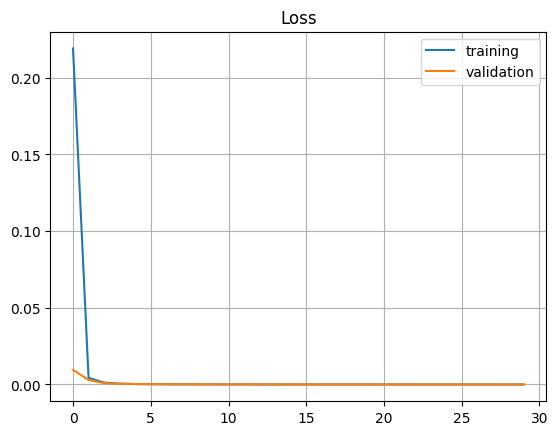

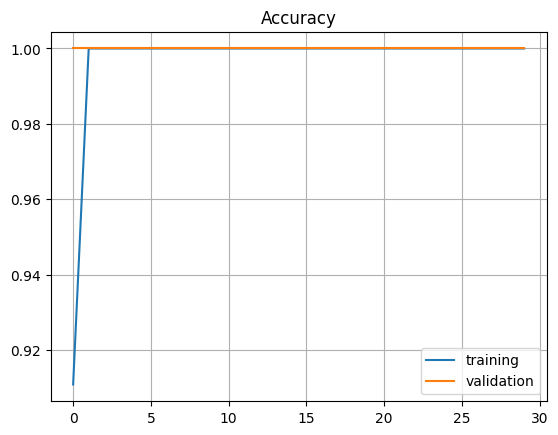

In [171]:
score = model.evaluate(x_test_normalized, y_test_encoded, verbose=1)
print('Test loss:', score[0])
print(f'Test accuracy: {score[1]*100} %')


#extract_data.load_data("MPA-MLF_data\Test", (72, 48))

plt.figure()
plt.title('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.grid('both')
plt.figure()
plt.title('Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.grid('both')

""" y_pred = model.predict(x_test_normalized)
#print(y_pred)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)
#print(y_pred_classes)
#print(y_true_classes)
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(cm)
ConfusionMatrixDisplay.from_predictions(y_true_classes,y_pred_classes)
plt.show() """

In [172]:
y_pred = model.predict(x_sub_normalized)
#print(y_pred)
y_pred_classes = np.argmax(y_pred, axis=1)
print(y_pred_classes)

import csv
with open('label_test_MT_v0.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['ID', 'target'])  # Write header
    for i, value in enumerate(y_pred_classes):
        writer.writerow([i, value])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[1 0 1 2 0 0 2 0 2 0 1 1 1 0 1 2 0 2 2 2 0 0 2 1 0 0 2 1 1 1 2 0 2 2 2 0 2
 0 0 0 1 2 1 0 1 2 1 0 2 1 1 0 2 0 0 1 0 1 2 0 2 1 1 2 1 1 2 1 0 2 1 1 2 2
 2 1 1 2 2 2 0 1 2 2 0 2 0 1 0 2 2 1 2 0 2 0 0 2 0 0 0 0 2 1 2 2 1 0 1 2 2
 0 1 1 0 1 2 0 0 1]
